### Run MAF on Multiple FBS_1.7 OpSims internight gap
for Opening paper of ApJS Focus Issue on Rubin Cadence work

In [1]:
# import matplotlib to show plots inline.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

Import the sims_maf modules needed.

In [2]:
# import lsst.sim.maf moduels modules
import rubin_sim.maf.db as db
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.plots as plots
import rubin_sim.maf.metricBundles as metricBundles

In [3]:
import seaborn


#### 1. Build connections to the OpSims databases

1. `dbDir`: The path to the OpSim database directory
2. `outDir`: The path to the directory where you want to save the metric metadata.



In [4]:
#!rm -r /home/idies/workspace/Storage/fbianco/persistent/OpeningPaperOutput

In [5]:
NS = 64 #healpix size
allfilters = ['any', 'u', 'g', 'r', 'i', 'z', 'y']
opsims = {0:"baseline_nexp2_v1_7_1_10yrs", 
          1:"rolling_nm_scale0_90_nslice2_fpw0_9_nrw1_0v1_7_10yrs"}


In [9]:
# Collect Run names to a list
dbRuns = glob.glob('*.db')
dbRuns

['rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db',
 'baseline_nexp2_v1.7.1_10yrs.db']

#### 3. Loop over all OpSims in dbDir and run MAF

In [13]:
# median tygap Metric
tgSlicer = slicers.HealpixSlicer(nside=NS)
tgConstraint0 = 'night > %f and night < %f' % (365.25*2.5, 365.25*3.5)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [14]:
outDirLeaf = 'temp'
rootPath = ''
resultDbPath = rootPath + outDirLeaf

resultDbPath

'temp'

In [15]:
opsims[0]

'baseline_nexp2_v1_7_1_10yrs'

In [22]:
# doing it separately for each filter. 
# this is time consuming but easier for me to operate on each output separately
for f in allfilters:
    #connect the db and output dir
    outDirfilt = resultDbPath + '/{}filter'.format(f)
    
    resultDbs = db.ResultsDb(outDir=outDirfilt)
    
    # Collect Run names to a list
    medianMetric = metrics.InterNightGapsMetric()
    summaryMetrics = [ metrics.MedianMetric()]
    
    metricDataPath = outDirfilt + '/MetricData/'
    if not os.path.exists(os.path.abspath(resultDbPath)):
        os.mkdir(os.path.abspath(resultDbPath))
    if not os.path.exists(os.path.abspath(metricDataPath)):
        os.system("mkdir " + metricDataPath)
        
    print(metricDataPath)
    
    for i,run in enumerate(dbRuns):
        opSimDbs = db.OpsimDatabase(run)
        if (opsims[0].split("v1")[0].replace('.','_') in run.replace('.','_') or 
            opsims[1].split("v1")[0].replace('.','_') in run.replace('.','_')):
    
            print("%s, %d/%d"%(f, i+1, len(opsims)))
            tgConstraint =  tgConstraint0
            
            if not f == 'any':
                tgConstraint += ' and filter = "%s"'%f 
            print(tgConstraint)
        
            mediantgSky = metricBundles.MetricBundle(medianMetric, tgSlicer, \
                tgConstraint)
            mediantgSky.setSummaryMetrics(summaryMetrics)
            # must set run name for each opSim to store metric data into
            bundleDict = {'mediantgSky': mediantgSky}
            # separate files
            mediantgSky.setRunName(run)
            metricGroup = metricBundles.MetricBundleGroup(bundleDict,\
                    opSimDbs, metricDataPath, resultDbs)
            metricGroup.runAll()
    

temp/anyfilter/MetricData/
any, 1/2
night > 913.125000 and night < 1278.375000
Querying database SummaryAllProps with constraint night > 913.125000 and night < 1278.375000 for columns ['rotSkyPos', 'observationStartMJD', 'fieldDec', 'fieldRA', 'night']
Found 204213 visits
Running:  ['mediantgSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
any, 2/2
night > 913.125000 and night < 1278.375000
Querying database SummaryAllProps with constraint night > 913.125000 and night < 1278.375000 for columns ['rotSkyPos', 'observationStartMJD', 'fieldDec', 'fieldRA', 'night']
Found 204914 visits
Running:  ['mediantgSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
temp/ufilter/MetricData/
u, 1/2
night > 913.125000 and night < 1278.375000 and filter = "u"
Querying database SummaryAllProps with constraint night > 913.125000 and night < 1278.375000 and filter = "u" for columns ['rotSkyPos', 'observationStart

In [23]:
os.listdir(metricDataPath)


['rolling_nm_scale0_90_nslice2_fpw0_9_nrw1_0v1_7_10yrs_db_Median_Inter-Night_Gap_night_gt_913_125000_and_night_lt_1278_375000_and_y_HEAL.npz',
 'baseline_nexp2_v1_7_1_10yrs_db_Median_Inter-Night_Gap_night_gt_913_125000_and_night_lt_1278_375000_and_y_HEAL.npz']

In [24]:
os.listdir(outDirfilt)

['resultsDb_sqlite.db', 'MetricData']

In [25]:
os.listdir(resultDbPath)

['yfilter', 'gfilter', 'zfilter', 'anyfilter', 'ifilter', 'rfilter', 'ufilter']

In [33]:
# create disctionary for the names of all metric outputs


baseline = {}
rolling = {}
for i,f in enumerate(allfilters):
    if f in ['any']:
        filtstring = ''
    else:
        filtstring = 'and_%s_'%f
    direct = 'temp/%sfilter/MetricData/' % f
    
    baseline[f] = np.load( glob.glob(direct+'baseline*')[0])
    rolling[f] = np.load( glob.glob(direct+'rolling*')[0])
    

Now you have computed your metric for all the opSims.  To look at those results, go through [View_Results.ipynb](./View_Results.ipynb).

Text(0.5, 1.0, 'u band distribution for baseline and rolling')

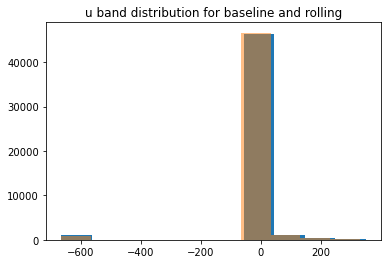

In [34]:
#plot one histogram to check whats up
plt.hist( rolling['u']["metricValues"], label="rolling")

plt.hist( baseline['u']["metricValues"], alpha=0.5, label="baseline")
plt.title("u band distribution for baseline and rolling")

Text(0.5, 1.0, 'u band distribution for rolling, cropped')

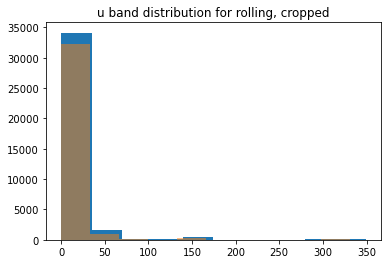

In [35]:
# need to set a cutoff... what is up with the tiny gaps and with the negative gaps?????)
plt.hist(rolling['u']["metricValues"][rolling['u']["metricValues"]>10**(-2)], 
         label="rolling")
plt.hist(baseline['u']["metricValues"][baseline['u']["metricValues"]>10**(-2)], 
         alpha=0.5, label="baseline")

plt.title("u band distribution for rolling, cropped")

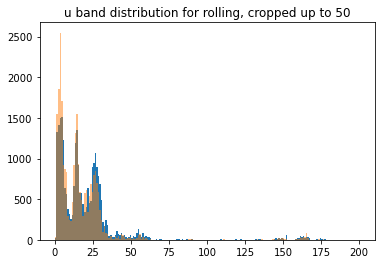

In [36]:
# need to set a cutoff... still there are ridiculous tails
plt.hist(rolling['u']["metricValues"][rolling['u']["metricValues"]>=1], 
         bins=np.linspace(0,200,200), label="rolling")
plt.hist(baseline['u']["metricValues"][baseline['u']["metricValues"]>=1], 
         bins=np.linspace(0,200,200), alpha=0.5, label="baseline")

plt.title("u band distribution for rolling, cropped up to 50");

In [37]:
# put the outputs in temporaru dataframes for the seaborn plots
# cut values from 1e-10 to 500
df1_ = pd.DataFrame({'bands':[], 'daysgap':[]})
df2_ = pd.DataFrame({'bands':[], 'daysgap':[]})

#peak = [4.5, 49, 22, 11, 11, 15, 25]
cmap = plt.cm.get_cmap('plasma')
colors = ['k'] + [cmap(i) for i in np.linspace(0, 1, 7)]


for i,f in enumerate(allfilters):
    selected = baseline[f]['metricValues']
    selected = selected[(selected > 1) * (selected < 500)]
    tmp_ = pd.DataFrame({'bands': [f] * len(selected),
                         'daysgap': selected})
    df1_ = pd.concat([df1_, tmp_])

    selected = rolling[f]['metricValues']
    selected = selected[(selected > 1) * (selected < 500)]
    tmp_ = pd.DataFrame({'bands': [f] * len(selected),
                         'daysgap': selected})
    df2_ = pd.concat([df2_, tmp_])
    #    df_[f] = (bl1[f])
df_ = [df1_, df2_]



In [38]:
from scipy.stats import gaussian_kde
import numpy as np

def estimate_maxima(data):
    kde = gaussian_kde(data)
    no_samples = 100
    samples = np.linspace(0, 100, no_samples)
    probs = kde.evaluate(samples)
    maxima_index = probs.argmax()
    maxima = samples[maxima_index]
    return maxima


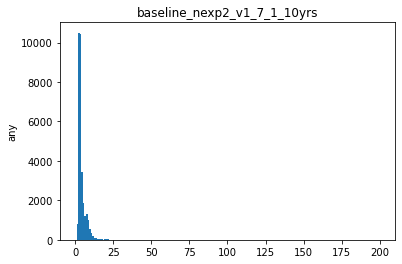

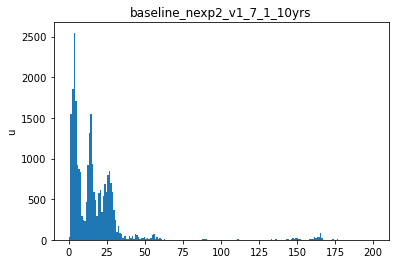

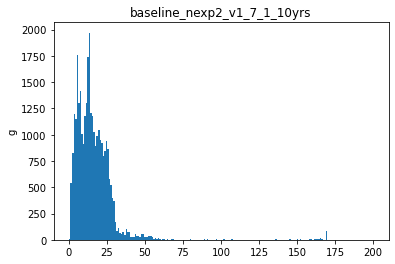

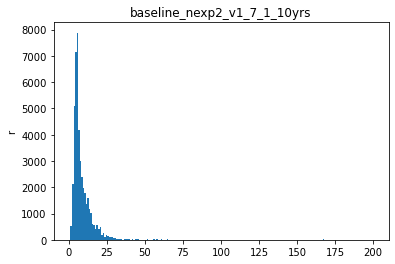

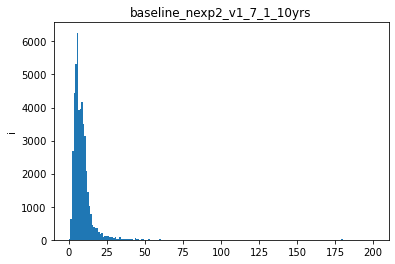

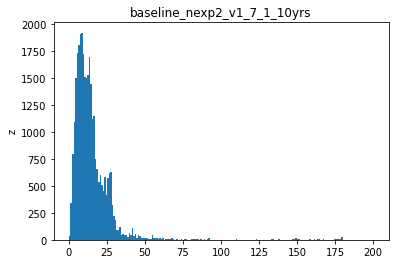

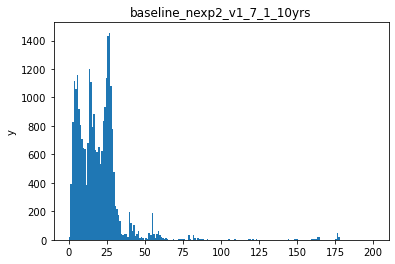

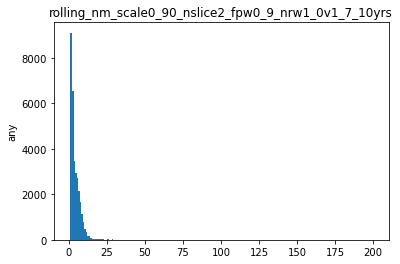

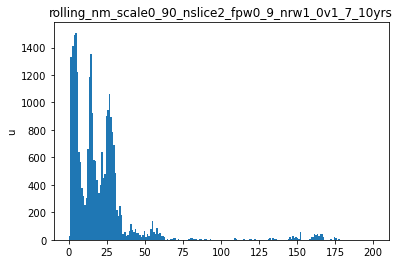

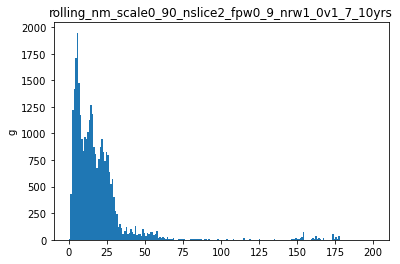

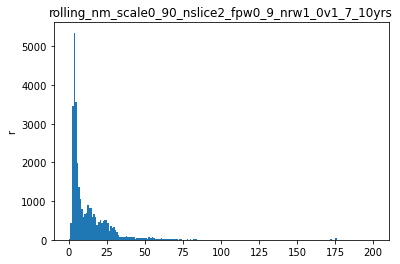

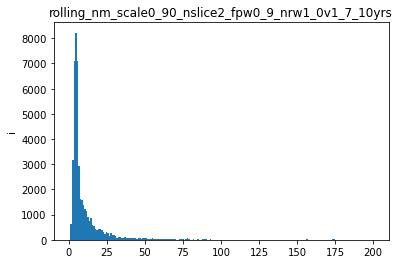

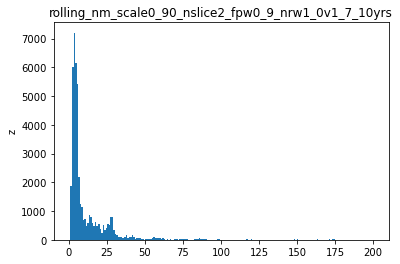

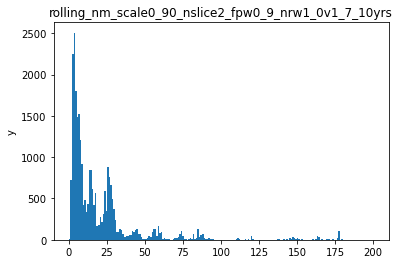

In [39]:
# plot all distributions

from sklearn.neighbors import KernelDensity

peaks = []
nobstotals = []

for j in range(2):
    peak = {}
    nobstotal = {}
    for i,f in enumerate(allfilters):
        
        if f in df_[j].bands.values:
            plt.figure();
            
            heights, bins, patches = plt.hist(df_[j][df_[j].bands == f]["daysgap"], 
                 bins=np.linspace(0,200,200), label="f")
            plt.ylabel(f)
            plt.title(opsims[j])
            plt.show();
            #peak[f] = bins[:-1][heights == heights.max()]
            peak[f] = estimate_maxima(df_[j][df_[j].bands == f]["daysgap"].dropna().values)
            nobstotal[f] = (df_[j].bands == f).sum()
            
    peaks.append(peak)
    nobstotals.append(nobstotal);

In [40]:
peaks, nobstotals

([{'any': 3.0303030303030303,
   'u': 5.050505050505051,
   'g': 13.131313131313131,
   'r': 5.050505050505051,
   'i': 5.050505050505051,
   'z': 8.080808080808081,
   'y': 25.252525252525253},
  {'any': 2.0202020202020203,
   'u': 5.050505050505051,
   'g': 7.070707070707071,
   'r': 4.040404040404041,
   'i': 5.050505050505051,
   'z': 4.040404040404041,
   'y': 6.0606060606060606}],
 [{'any': 32305,
   'u': 26293,
   'g': 31603,
   'r': 46263,
   'i': 47044,
   'z': 31410,
   'y': 27092},
  {'any': 32302,
   'u': 26365,
   'g': 31221,
   'r': 31810,
   'i': 46545,
   'z': 46127,
   'y': 26736}])

0
1
2
3
4
5
6
0
1
2
3
4
5
6


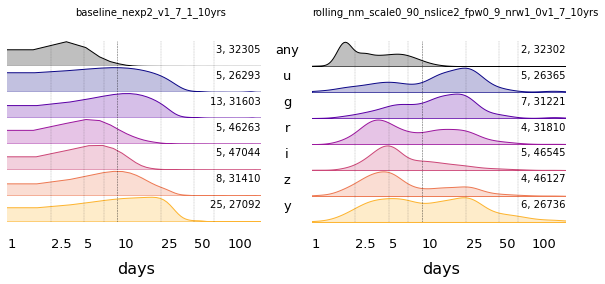

In [41]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10,4), sharex=True, squeeze=True)
plt.subplots_adjust(hspace=0)
plt.subplots_adjust(bottom=0.25)

for j in range(2):
    for i,f in enumerate(allfilters):
        print(i)
    
        seaborn.kdeplot(data=df_[j][(df_[j].bands == f)].daysgap, 
                    shade=True, bw_adjust=2, ax=ax[i][j], color=colors[i], 
                        legend=False,
                    clip=(0.0, 500.0))
        ax[i][j].axis('off')
        ax[i][j].text(200, ax[i][j].get_ylim()[1]*0.55, 
               "%d, %d"%(peaks[j][f], nobstotals[j][f]), ha='right')
        
        ylim = ax[i][j].get_ylim()
        if j==1:
            ax[i][j].text(0.6, ylim[1]/2, f, fontsize=13, ha='center')
       
        ax[i][j].plot([10,10], ylim, 'k--', lw=0.5, alpha=0.7)
        
        for x in [2.5,5,7.5,25,50,75]:
            ax[i][j].plot([x,x], ylim, 'k--', lw=0.3, alpha=0.5)
    
        ax[i][j].set_ylim(ylim)
    ll = -ax[-1][j].get_ylim()[1]

    #ax[i][j].set_xlim(0,100)
    plt.axis('off')
    plt.xlabel("")
    plt.xticks([])
    plt.xscale('log')
    plt.xlim(1, 200)
    ax[-1][j].text(20, -ll*8, opsims[j], ha='center')
    ax[-1][j].text(1, ll, '1', fontsize=13)
    ax[-1][j].text(10, ll, '10', fontsize=13)
    # #ax[-1].text(100, -0.1, '100', fontsize=13)
    ax[-1][j].text(10, ll*2, 'days', fontsize=16);
    ax[-1][j].text(2.5,ll, '2.5', fontsize=13)
    ax[-1][j].text(5, ll, '5', fontsize=13)
    #ax[-1][j].text(7.5, ll, '7.5', fontsize=13)
    ax[-1][j].text(25, ll, '25', fontsize=13)
    ax[-1][j].text(50, ll, '50', fontsize=13)
    ax[-1][j].text(100, ll, '100', fontsize=13);
    plt.xlabel("days")
#fig.tight_layout()

plt.savefig("internightgapv171.pdf", )